## Evaluation of Text-to-Image Conditional Diffusion Model with Classifier-Free Guidance

This notebook evaluates the pre-trained text-to-image diffusion model on generating flower images. The assessment focuses on both the quality of the generated images and an analysis of the model's internal representations. The main steps of the evaluation are:

- **Image Generation:** Produce high-quality flower images from text prompts using the conditional UNet-DDPM model with Classifier-Free Guidance (CFG).  
- **Embedding Extraction:** Capture intermediate feature representations from the U-Net’s downsampling path during generation to analyze what the model has learned.  
- **Quantitative Evaluation:** Measure generation quality using **CLIP Score** and **Fréchet Inception Distance (FID)**.  
- **Visualization & Analysis:** Create a FiftyOne dataset to inspect generated images, metadata, and embeddings; use FiftyOne Brain to compute uniqueness and representativeness scores.  
- **Experiment Tracking:** Log hyperparameters, metrics, and evaluation results to the [diffusion-model-assessment-v2 W&B project](https://wandb.ai/handsoncv-research/diffusion-model-assessment-v2/workspace) for reproducibility and comparison across experiments; for reefrence, see the runs `*-evaluation`.  

In the following cell, we import modules and functions from our `src` package, set random seeds for reproducibility, and define the parameters and file paths used throughout the notebook.

> **Note:** You can also use the cell in Part 6 of this notebook directly if your goal is to download the generated images and analyze them with FiftyOne, without needing to reproduce the evaluation from scratch. 

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import clip
import os 

# On a multi-GPU system, this hides all GPUs except the first 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import fiftyone as fo
import fiftyone.brain as fob
import torchvision.transforms as transforms
import wandb 
import pandas as pd
from IPython.display import display, HTML

from torch.utils.data import DataLoader
from huggingface_hub import snapshot_download

# Custom modules
from handsoncv.datasets import TFflowersCLIPDataset
from handsoncv.models import UNet
from handsoncv.utils import DDPM, set_seed
from handsoncv.evaluation import Evaluator

# Hardware & Paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-3")
ROOT_DATA = os.path.join(ROOT_PATH, "data")
DATA_DIR = f"{ROOT_DATA}/cropped_flowers"
SAMPLE_DIR = f"{ROOT_DATA}/05_images"
CSV_PATH = f"{ROOT_DATA}/clip_embeddings_metadata.csv"

CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Numpy and Torch Reproducibility
SEED=42
set_seed(42)

# Base Configuration Parameters
BATCH_SIZE = 32
HF_REPO_ID = "vanessaguarino/TFflowers-diffusion-assessment"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
Seeds set to 42 for reproducibility.


### Data & Model Loading

In the following section, we load the UNet model trained in the notebook `05_a_*.ipynb`. The model architecture and its key improvements over the original NVIDIA reference implementation are described in the corresponding training notebook and implemented in `src/models.py`.

The pretrained weights are loaded using the `torch.load_state_dict` function. Two types of checkpoints are available: one corresponding to the best validation loss and another corresponding to the best CLIP score achieved during training. In this notebook, we explicitly select the checkpoint with the best validation loss**, while retaining the CLIP-optimized checkpoint for alternative evaluation and comparison.

In addition, we instantiate the DDPM forward and reverse diffusion processes using the DDPM class provided in `src/utils.py`.

In [2]:
# Load UNet/DDPM trained in notebook '05_a_*'
model = UNet(400, 3, 32, down_chs=(256, 256, 512)).to(DEVICE)
model.load_state_dict(torch.load(f"{CHECKPOINTS_DIR}/ddpm_unet_best_model.pt"))

ddpm = DDPM(torch.linspace(0.0001, 0.02, 400).to(DEVICE), DEVICE)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE)

For evaluation, we reuse the same custom `TFflowersCLIPDataset` and preprocessing pipeline defined in the training notebook (`05_a_*.ipynb`) to ensure consistency between training and evaluation data handling. Images are resized to `32×32`, normalized to the `[-1, 1]` range, and loaded together with their precomputed CLIP embeddings.

Unlike the training setup, no train/validation split is used at this stage: diffusion models learn data distributions rather than predictive tasks, and sample quality is better assessed via qualitative inspection and distributional metrics such as FID and CLIP. Given the limited dataset size, further partitioning would reduce the number of available samples and weaken the reliability of evaluation analyses, so the full dataset is used as the reference set of real images.

To ensure reproducibility, a fixed random seed is applied through a `torch.Generator`, even though the data loader is configured without shuffling.

In [3]:
# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

# Base transforms used by both training and validation data
base_t = [
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
]

# Create a DataLoader for original (real) images
ds = TFflowersCLIPDataset(CSV_PATH, transform=transforms.Compose(base_t))
data_loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, generator=g)

### Part 1 & 2 — Image Generation, Embedding Extraction, Evaluation with CLIP Score & Frechet Inception Distance 

In this section, we stochastically generate flower images from the learned data distribution using the trained conditional UNet-DDPM model and evaluate the results both quantitatively and representationally. The evaluation pipeline is fully encapsulated in the `Evaluator` class defined in `src/evaluation.py`.

Given a list of text prompts, a reference dataloader of real images, and a fixed classifier-free guidance weight (set to $3.0$, based on qualitative inspection), the evaluation is executed via the `sample_flowers` function. This function—defined in `src/utils.py` and adapted from NVIDIA’s reference notebook—performs conditional sampling while optionally extracting intermediate feature representations from the U-Net bottleneck. Bottleneck embeddings are captured through a forward hook registered on the `down2` module and stored during a single forward pass at timestep $t = 0$, enabling analysis of the model’s representations in the next Section. Generated images and corresponding embeddings are saved as `.png` and `.npy` files when a `results_dir` is specified.

---

1. **CLIP Score**

Semantic alignment between generated images and their conditioning text prompts is measured using the CLIP Score, computed as the cosine similarity between image and text embeddings produced by a pretrained CLIP model. Higher CLIP scores indicate stronger correspondence between visual content and textual description. In our implementation (`calculate_clip_score` in `src/metrics.py`), both image and text embeddings are $\ell$2-normalized prior to similarity computation.

--- 

2. **Fréchet Inception Distance (FID)**

Distribution-level similarity between generated and real images is assessed using the Fréchet Inception Distance (FID). FID is computed from $2048$-dimensional feature vectors extracted from the pooled layer of a pretrained `InceptionV3` network. Lower FID values indicate closer alignment between the real and generated image distributions. Feature extraction and FID computation are implemented in `extract_inception_features` and `calculate_fid`, respectively, within `src/metrics.py`.

> **Note on data normalization:** Both real and generated images are stored in the range $[-1, 1]$. For FID computation, images are first rescaled to $[0, 1]$ and then normalized using ImageNet statistics before being passed through InceptionV3.

> **Note on statistical significance:** Reliable FID estimation typically requires several thousand generated samples to adequately cover the data distribution. Given the limited size of the original dataset ($\approx 1000$ images), we generate a comparable number of samples ($\approx 920$) in this evaluation to maintain consistency of the estimator.

> **Note on GPU memory:** Generating and evaluating large batches of images can be memory-intensive. To avoid GPU out-of-memory errors, it is recommended to restart the kernel before running this notebook from start to finish.

In [4]:
# Assessment Part 1 & 2: Generation, Embedding Extraction, CLIP Score and FID
# For inspection of the exact functions, please refer to sample_flowers in src/handsoncv/utils.py and Evaluator class in src/handsoncv/evaluation.py
evaluator = Evaluator(model, ddpm, clip_model, clip_preprocess, DEVICE, results_dir="results/eval_01")

# Define list of text prompts to generate images for
text_prompts = [
    "A red rose flower",
    "A deep red rose",
    "A rose with layered petals",
    "A red rose with layered petals",
    "A pink rose flower",
    "A detailed rose flower",
    "A close-up of a rose",
    
    "Two sunflowers with big brown centers",
    "A sunflower flower",
    "A sunflower with bright yellow petals",
    "An orange sunflower with a big brown center",
    "A bright yellow sunflower",
    "A close-up of a sunflower",
    "A large sunflower",
    "A sunflower with limp, drooping petals",
    
    "A white daisy with a yellow center",
    "A round white daisy",
    "A daisy flower",
    "A detailed daisy flower",
    "A close-up of a daisy",
    "A daisy covered in dew",
    "Two daisies",
    "Two white daisies with yellow centers",
]

eval_results, fid = evaluator.run_full_evaluation(
    text_prompts * 40,
    real_dataloader=data_loader,
    w_tests=[3.0],
)

print(f"FID Score: {fid}")

FID Score: 87.5003101935098


After computing and printing the FID score for the 920 generated images, we display a table showing the first 23 generations. For each image, the table includes the text prompt, the CLIP score, the image filename (as stored in `results/eval_01`), and a small preview of the generated image.

In [18]:
# Create a table for the first 23 images generated for the text prompts
display_df = pd.DataFrame([{
    "Prompt": r["prompt"],
    "CLIP Score": r["clip_score"],
    "Image": r["img_path"]
} for r in eval_results[:23]])

# Generate HTML thumbnails for each image
display_df["Preview"] = display_df["Image"].apply(
    lambda x: f"<img src='{x}' width='45' style='border:1px solid gray' />"
)

# Shorten image path for readability
display_df["Image"] = display_df["Image"].apply(lambda x: x.split("/")[-1])

# Display the table with thumbnails
display(HTML(display_df.to_html(escape=False, index=False)))

Prompt,CLIP Score,Image,Preview
A red rose flower,0.270264,gen_000.png,
A deep red rose,0.247559,gen_001.png,
A rose with layered petals,0.261963,gen_002.png,
A red rose with layered petals,0.273438,gen_003.png,
A pink rose flower,0.289795,gen_004.png,
A detailed rose flower,0.199585,gen_005.png,
A close-up of a rose,0.218506,gen_006.png,
Two sunflowers with big brown centers,0.205566,gen_007.png,
A sunflower flower,0.297852,gen_008.png,
A sunflower with bright yellow petals,0.306152,gen_009.png,


#### Quantitative Analysis of Generation
1. **FID Score ($87.5$)**: While this is high compared to state-of-the-art models (which often score $<10$), it is expected given the constraints. FID is sensitive to:  
    - Sample Size: We compare $\approx 920$ images against a small real dataset (TF-Flowers). FID calculation requires thousands of images to ensure a consistent and unbiased estimator.
    - Resolution: At 32×32, upscaling to InceptionV3's expected 299×299 introduces artifacts, degrading the score.
2. **CLIP Scores ($\in [.20,.31]$)**: These scores indicate reasonable semantic alignment between text prompts and generated images. For `ViT-B/32`, scores above 0.25 typically signal clear class differentiation.  
    - Highest Performance: "_Two white daisies with yellow centers_" ($0.316$) and "_A sunflower with bright yellow petals_" ($0.306$).  
    - Lowest Performance: "_A detailed rose flower_" ($0.199$), suggesting the model captures basic color and shape more reliably than abstract textual details.  

Some experimental setups, including self-attention at the bottleneck and data augmentation strategies inspired by the DDPM standard ([Ho et al., 2020](https://arxiv.org/pdf/2006.11239)), were tested and logged to [diffusion-model-assessment-v2](https://wandb.ai/handsoncv-research/diffusion-model-assessment-v2/workspace) under `*_training` runs. However, these modifications did not improve performance due to the small dataset:  
   - **Self-Attention:** The model overfits or fails to generalize long-range spatial dependencies when there are too few images.  
   - **Augmentations:** Complex augmentations like jittering or heavy cropping add noise that prevents the model from learning correct color-to-class associations. The original images were already close-cropped, limiting viewpoint diversity.  

Overall, resolution and dataset size are the main bottlenecks: the model reproduces essential, repeated features of each flower type (e.g., yellow disk of daisies, brown center of sunflowers) but cannot capture fine-grained textures or details of petals and leaves. Moreover, the colours appear slightly oversaturated due to the use of a strong, optimal positive guidance weight of $w^*=3.0$. However, this did appear to display the flowers' features more distinctly and the CLIP conditioning seems to conduct the pipeline when distinguishing between a red and pink rose (`gen_000` vs `gen_004`).

---

### Part 3 — UNet Embedding Analysis with FiftyOne Brain

In this section, we analyze the internal representations of the UNet model using **FiftyOne Brain**. We create a dataset containing the first $500$ generated images (or fewer, depending on the evaluation), along with their associated metadata:

- **Prompt**: The text input used to generate each image.  
- **CLIP Score**: The semantic alignment score between the image and its prompt.  
- **UNet Embedding**: The intermediate feature vector extracted from the bottleneck of the UNet.

Once the samples are added to the dataset, we compute two key brain metrics:  
- **Uniqueness:** Measures how distinct each generated sample is relative to the others.  
- **Representativeness:** Assesses how well the generated images cover the feature space defined by the UNet embeddings.  

Finally, the FiftyOne app is launched for interactive inspection of the generated images, their embeddings, CLIP scores, and prompt associations. This allows qualitative exploration and deeper insight into how the UNet encodes semantic and visual information across the generated dataset.

After running this cell, follow the instructions printed below to access the app:

1. If the inline app view is blank, check the 'PORTS' tab in VS Code.  
2. Ensure port `5151` is forwarded to `127.0.0.1:5151`.  
3. Open the link provided in your local browser ([http://127.0.0.1:5151](http://127.0.0.1:5151)).  
4. In the app, go to the “PRIMITIVES” tab (bottom left) and select “Representativeness”, “Uniqueness” and “CLIP Scores” to visualize the computed metrics for each sample.  
5. Click on any sample to view the generated flower image, its CLIP score, and the corresponding “unet_embedding” vector in the "OTHERS" tab.

> **Note**: FiftyOne requires at least 20 samples to compute representativeness. If fewer samples are available, only uniqueness is calculated.  

 100% |█████████████████| 500/500 [3.3s elapsed, 0s remaining, 154.4 samples/s]      
Computing brain metrics...
Computing embeddings...
 100% |█████████████████| 500/500 [1.6s elapsed, 0s remaining, 311.7 samples/s]      
Computing uniqueness...
Uniqueness computation complete
Computing representativeness...
Computing clusters for 500 embeddings; this may take awhile...
Representativeness computation complete



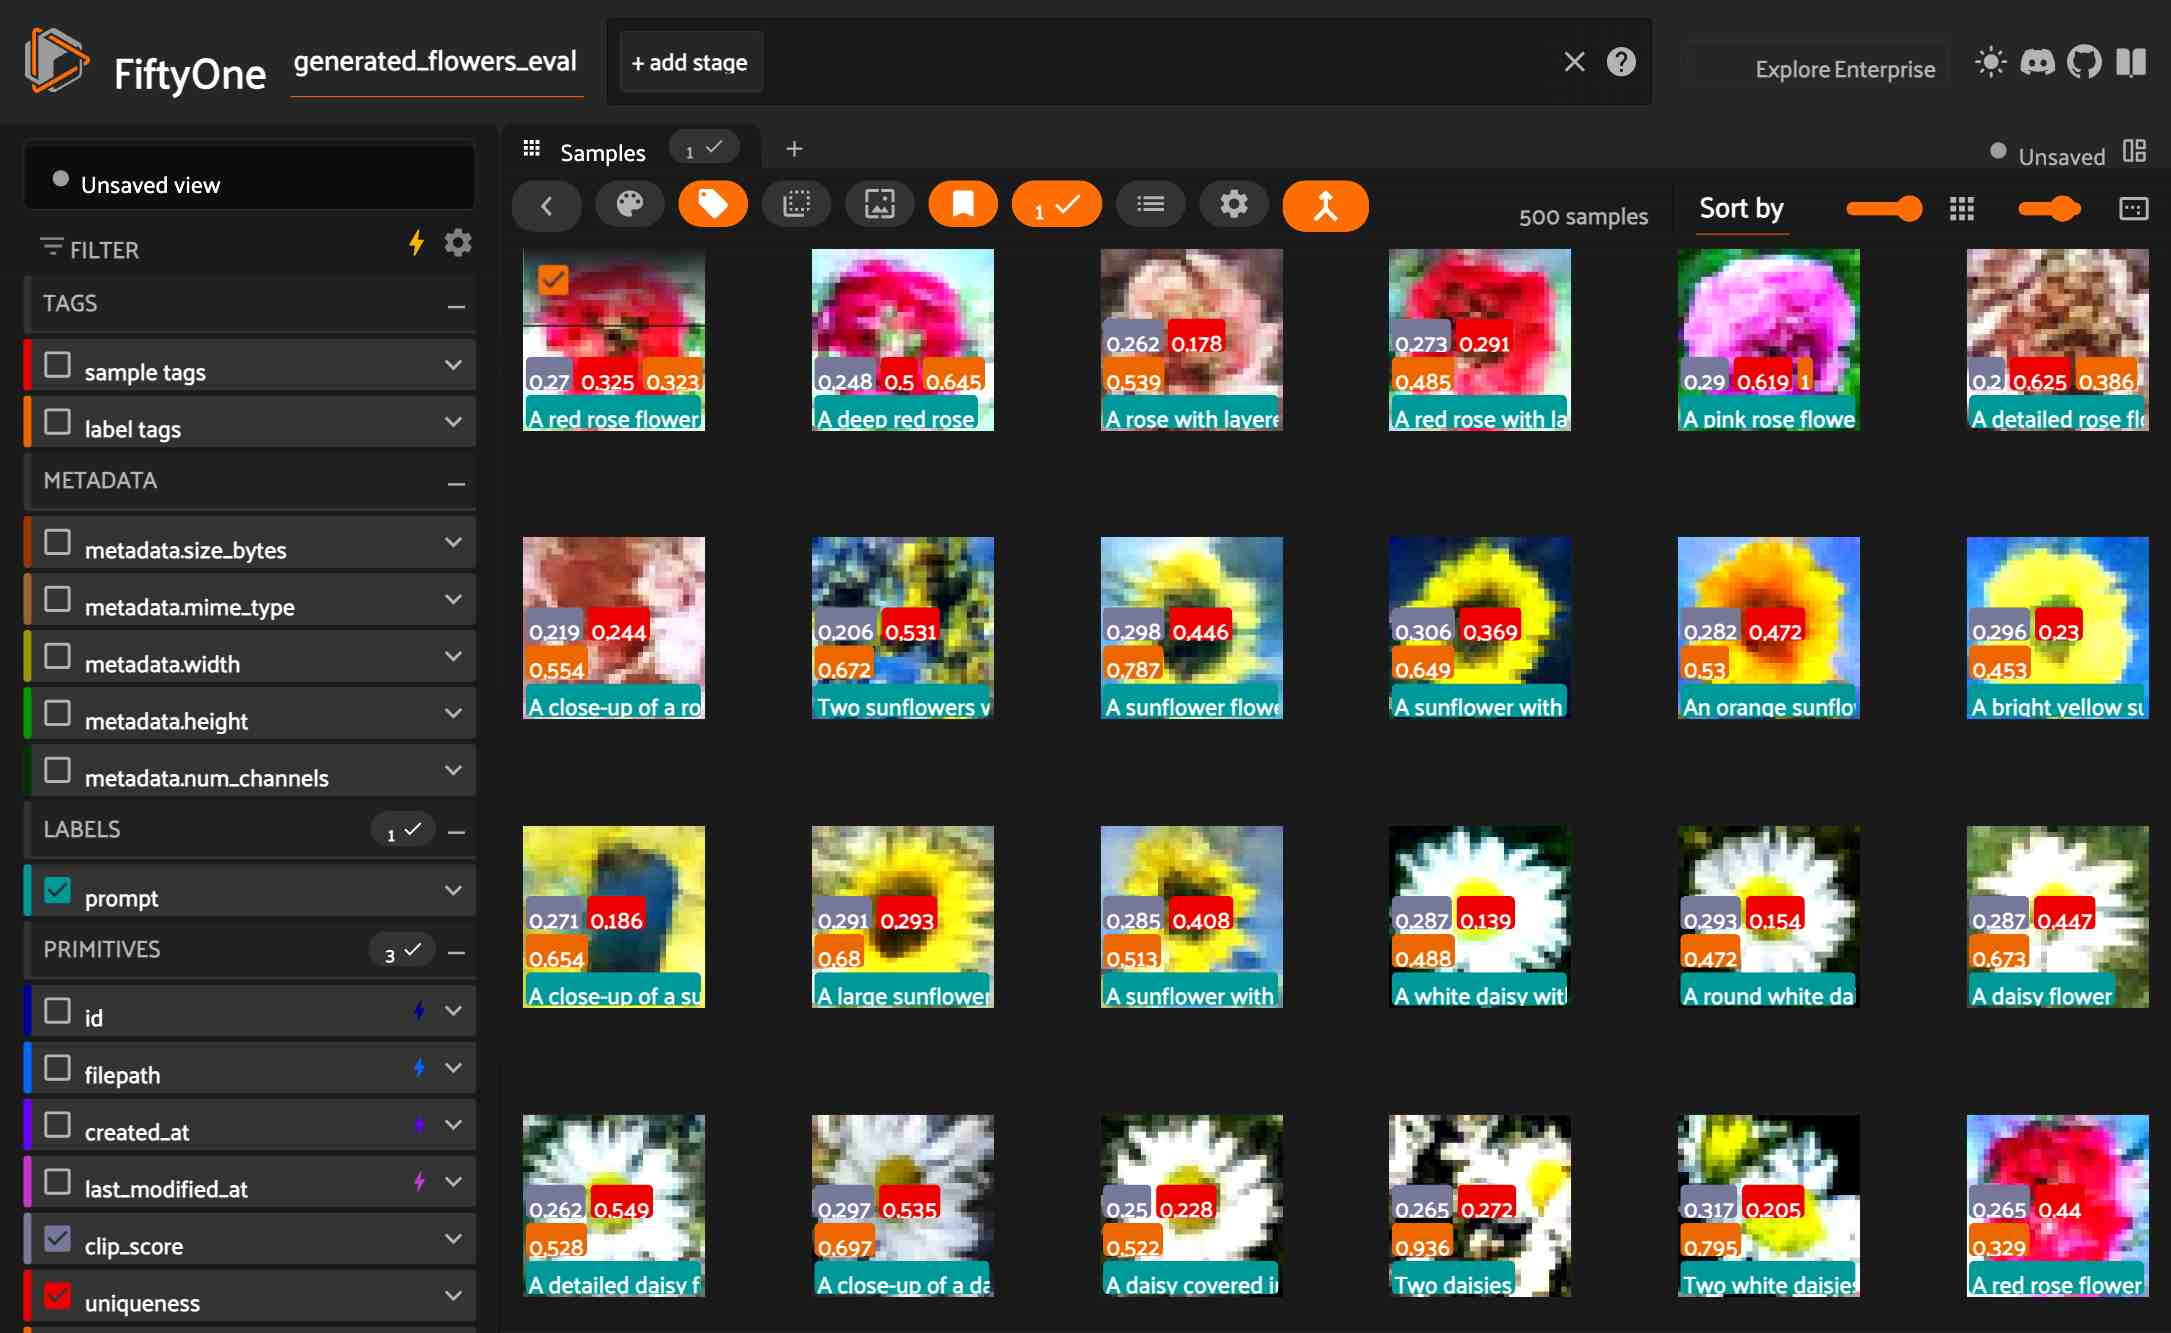

In [ ]:
# Define FiftyOne dtaaset and no. of sample to evaluate
dataset = fo.Dataset(name="generated_flowers_eval", overwrite=True)
FO_SAMPLES = 500 #len(text_prompts)
samples = []

# eval_results contains 920 items (23 unique prompts * 40 stochastic generations per prompt * 1 "visually-optimal" guidance scale)
for res in eval_results[:FO_SAMPLES]: 
    sample = fo.Sample(filepath=res["img_path"])
    sample["prompt"] = fo.Classification(label=res["prompt"])
    sample["clip_score"] = res["clip_score"]
    sample["unet_embedding"] = res["embedding"]
    samples.append(sample)

dataset.add_samples(samples)

# Run if we have enough samples to satisfy FiftyOne's default clustering
if len(dataset) >= 20:
    print("Computing brain metrics...")
    fob.compute_uniqueness(dataset)
    fob.compute_representativeness(dataset, embeddings="unet_embedding")
else:
    print(f"Dataset size ({len(dataset)}) is too small for representativeness (needs 20+).")

session = fo.launch_app(dataset)

#### Qualitative & UNet Embeddings Analysis of Generation

With $500$ samples, FiftyOne Brain metrics provide a statistically meaningful view of how the model clusters its learned representations:

1. **Representativeness:** Measures how "central" a sample is in the latent space.  
   - **Daisies as Anchors:** Prominent examples like "_Two daisies_" (Repr: $0.936$) and "_A sunflower flower_" (Repr: $0.787$) show high representativeness. The UNet is most consistent when generating high-contrast, center-weighted objects, which serve as prototypes in the latent space.  
   - **Roses as Peripheral Samples:** Prompts such as "_A red rose flower_" (Repr: $0.323$) are less central. Even with a high CLIP score, the model interprets layered roses as more variable than the radial daisy pattern. The exception is "A pink rose flower" (Repr: $1.000$), which appears more generalist, likely reflecting features shared across multiple rose samples seen during training.
   - **Effect of No Attention:** Without global attention, the model relies on local convolutions, excelling at reproducing radial symmetry but struggling with complex arrangements.

2. **Uniqueness:** Identifies samples with features that deviate from surrounding images.  
   - **Color Variation:** "_A pink rose flower_" (Uniq: $0.619$) stands out compared to standard red roses ($0.325$).  
   - **Spatial Complexity:** "_Two sunflowers..._" (Uniq: $0.531$) is more unique than a single sunflower, reflecting the model’s difficulty coordinating multiple objects without self-attention.

3. **Detailed Prompts:** The prompt "_A detailed rose flower_" (CLIP: $0.2$, Repr: $0.386$, Uniq: $0.625$) produces high-frequency noise or irregular gradients. Limited resolution (32×32) and lack of attention prevent the model from generating true fine-grained textures.

4. **Background Influence:** Recurring dark green/brown backgrounds affect bottleneck embeddings. Flowers blending with this learned background (e.g., sunflowers) achieve higher representativeness than sharply contrasting flowers like red roses.

> **Conclusion:** FiftyOne analysis shows that the UNet bottleneck is structurally most stable for centered, radial patterns. The lack of global attention has made the model specialized in reproducing circular symmetry, while CLIP conditioning ensures color alignment with prompts.


### Part 4 — Logging with Weights & Biases and Storing FiftyOne Dataset Locally

In this final section, we log the evaluation results to [diffusion-model-assessment-v2](https://wandb.ai/handsoncv-research/diffusion-model-assessment-v2) and export the FiftyOne dataset for local inspection.  

- **W&B Logging:** We initialize a W&B run in the `diffusion-model-assessment-v2` project, under the run names `ddpm_unet_evaluation` (job type: `evaluation`). Hyperparameters, model architecture, and evaluation setup are logged, including:
  - Number of diffusion timesteps (`T`)
  - Image size (`IMG_SIZE`)  
  - Guidance weight used (`w = 3.0`)  
  - UNet architecture (`ddpm_unet`)  
  - Number of generated samples and the bottleneck embedding dimension  
  - Prompts used for generation  

- **Aggregate Metrics:** We log the final FID score and the average CLIP score across the FiftyOne dataset.  

- **Results Table:** A W&B table is created for individual sample analysis, storing:
  - Generated image (with preview)  
  - Text prompt  
  - CLIP score  
  - Uniqueness  
  - Representativeness  

- **FiftyOne Export:**  
  The FiftyOne dataset is exported locally to `hf_flower_evaluation_export`, which contains:
  - `data/` — all generated images  
  - `samples.json` — metrics for each sample  
  - `metadata.json` — dataset and experiment info  

In [23]:
# Initialize W&B Run
run = wandb.init(
    project="diffusion-model-assessment-v2", 
    name="ddpm_unet_evaluation",
    job_type="evaluation"
)

# Log Hyperparameters
BOTTLE_EMB_CHANNELS = model.down2.model[-2].model[0].out_channels #extracted from the output channels of the model's `down2` layer
IMG_SIZE = next(iter(data_loader))[0].shape[-1] #extracted from first dataloader sample

wandb.config.update({
    "T": model.T,
    "img_size": IMG_SIZE, #extracted from first dataloader sample
    "guidance_weight_w": 3.0, # Or the specific value set in evaluator.run_full_evaluation() as w_tests
    "architecture": "ddpm_unet",
    "num_samples": len(dataset),
    "embedding_size": BOTTLE_EMB_CHANNELS,
    "prompts": text_prompts,
})

# Log Aggregate Evaluation Metrics
avg_clip_score = dataset.mean("clip_score") # Compute average CLIP score from the FiftyOne dataset

wandb.log({
    "final_fid_score": fid,
    "average_clip_score": avg_clip_score
})

# Create and Log the Results Table
# We iterate through the FiftyOne dataset to get the brain metrics 
results_table = wandb.Table(columns=[
    "generated_image", 
    "text_prompt", 
    "clip_score", 
    "uniqueness", 
    "representativeness"
])

print("Syncing FiftyOne results to WandB Table...")

for sample in dataset:
    # Convert image tensor/path to wandb.Image
    img = wandb.Image(sample.filepath, caption=sample.prompt.label)  # We use the absolute path stored in FiftyOne
    
    # Add row to table
    results_table.add_data(
        img,
        sample.prompt.label,
        sample.clip_score,
        sample.uniqueness,
        sample.representativeness
    )

# Log the table to W&B
wandb.log({"evaluation_results_table": results_table})

# Finish the run
print("Evaluation logging complete!")
run.finish()

wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Syncing FiftyOne results to WandB Table...
Evaluation logging complete!


average_clip_score,▁
final_fid_score,▁
average_clip_score,0.27309
final_fid_score,87.50031


We then export the FiftyOne dataset locally and prepare it for upload to the Hugging Face Dataset repository at [vanessaguarino/TFflowers-diffusion-assessment](https://huggingface.co/datasets/vanessaguarino/TFflowers-diffusion-assessment) using the Hugging Face CLI workflow. This ensures that all generated images, embeddings, and evaluation metrics are preserved

#### Step 1 — Add YAML Metadata
Paste the following `YAML` header at the very top of the `README.md` inside the local export folder (`./data/hf_flower_evaluation_report`) to categorize the data as the `test` split:

```yaml
---
dataset_info:
  configs:
  - config_name: default
    data_files:
    - split: test
      path: "test/samples.json"
---
# Flower Diffusion Assessment Results
This dataset contains the FiftyOne export of the diffusion evaluation.
- **Split**: Test / Evaluation
- **Format**: FiftyOneDataset
```

#### Step 2 — Authenticate Hugging Face CLI

```bash
huggingface-cli login --token YOUR_HF_TOKEN
```

#### Step 3 — Create and Upload Dataset
Replace `your-username` with your actual HF username

```bash
# Create a new dataset repository. Usage: huggingface-cli upload [REPO_ID] [LOCAL_FOLDER] [REMOTE_FOLDER]
huggingface-cli repo create your-username/TFflowers-diffusion-assessment --repo-type dataset

# Upload the local export folder to the dataset by pointing either to the root directory using `.` or directly to the `test/` subfolder by using `test` as the upload path.
huggingface-cli upload your-username/TFflowers-diffusion-assessment ./data/hf_flower_evaluation_report test --repo-type dataset
```

In [24]:
# Define the export path and a metadata.jsonl file so the scores show up in the table
export_dir = os.path.join(ROOT_DATA, "hf_flower_evaluation_export")

# Perform the export
# This creates a folder containing:
# - data/ (the images)
# - samples.json (all metrics: clip_score, uniqueness, representativeness, embeddings)
# - metadata.json (dataset info)
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True
)

print(f"FiftyOne dataset exported to {export_dir}")

Directory '/home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/data/hf_flower_evaluation_export' already exists; export will be merged with existing files
Exporting samples...
   0% ||-------------------|   0/500 [349.3us elapsed, ? remaining, ? docs/s] 

 100% |████████████████████| 500/500 [545.5ms elapsed, 0s remaining, 916.6 docs/s]      
FiftyOne dataset exported to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/data/hf_flower_evaluation_export


### Part 5 — Verify Data Download from Hugging Face and into FiftyOne Dataset Object

In this section, we verify that the dataset was correctly uploaded to Hugging Face by downloading the snapshot and loading it back into a FiftyOne dataset object. This allows us to inspect the exported images, embeddings, and evaluation metrics just as before.

We first download the dataset snapshot using `snapshot_download`, then create a new FiftyOne dataset from the local files. Finally, we launch the FiftyOne app to visually confirm that all samples, metadata, and computed metrics have been preserved correctly.

In [ ]:
# Download the snapshot from Hugging Face
local_dir = snapshot_download(repo_id=HF_REPO_ID, repo_type="dataset")
fiftyone_dataset_name = "restored_flower_assessment"

if fiftyone_dataset_name in fo.list_datasets():
    fo.delete_dataset(fiftyone_dataset_name)
    
test_data_dir = os.path.join(local_dir, "test")

# Load it back into FiftyOne
restored_dataset = fo.Dataset.from_dir(
    dataset_dir=test_data_dir, # Also, local_dir would work, as it is a copy of test folder
    dataset_type=fo.types.FiftyOneDataset,
    name=fiftyone_dataset_name
)

# Verify
print(restored_dataset)
fo.launch_app(restored_dataset)

Fetching ... files: 0it [00:00, ?it/s]

Importing samples...
 100% |█████████████████| 500/500 [178.6ms elapsed, 0s remaining, 2.8K samples/s]     
Name:        restored_flower_assessment
Media type:  image
Num samples: 500
Persistent:  False
Tags:        []
Sample fields:
    id:                 fiftyone.core.fields.ObjectIdField
    filepath:           fiftyone.core.fields.StringField
    tags:               fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:         fiftyone.core.fields.DateTimeField
    last_modified_at:   fiftyone.core.fields.DateTimeField
    prompt:             fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    clip_score:         fiftyone.core.fields.FloatField
    unet_embedding:     fiftyone.core.fields.VectorField
    uniqueness:         fiftyone.core.fields.FloatField
    representativeness: fiftyone.core.fields.FloatField


Dataset:          restored_flower_assessment
Media type:       image
Num samples:      500
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/